# License

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at . 

      http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,  
software distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

In [0]:
# @title Upload files (skip this if this is run locally)

# Use this cell to update the following files
#   1. requirements.txt
from google.colab import files
uploaded = files.upload()

In [0]:
# @title Install missing packages

# run this cell to install packages if some are missing
!pip install -r requirements.txt

In [0]:
# @title Import libraries

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import gcsfs
import sklearn.metrics

%matplotlib inline

# Data inspection

## Utility for loading and transforming raw data

In [0]:
def load_main_energy_data(path):
  """Load main energy data from the specified file.
  
  Load main energy data from the specified file.
  
  Args:
    path - string. Path to the data file.
  Returns:
    pd.DataFrame - Main energy data in the household.
  Raises:
    ValueError. Raised when the specified file does not exist.
  """
  
  if not os.path.exists(path):
    raise ValueError('File {} does not exist.'.format(path))
  
  with open(path, 'r') as f:
    data = pd.read_csv(f,
                       delimiter=' ',
                       header=None,
                       names=['time',
                              'main_watts',
                              'main_va',
                              'main_RMS'])
  
  data.time = data.time.apply(lambda x: datetime.fromtimestamp(x))
  data.set_index('time', drop=True, inplace=True)
  data.index = data.index.floor('S')
  return data

In [0]:
def load_appliance_energy_data(path, appliance_name):
  """Load appliance energy data from file.
  
  Load energy data from the specified file.
  
  Args:
    path - string. Path to the data file.
    appliance_name - string. Name of the appliance.
  Returns:
    pd.DataFrame. A 2-column dataframe.
    The 1st column is timestamp in UTC, and the 2nd is energy in 
  Raises:
    ValueError. Raised when the specified file does not exist.
  """
  
  if not os.path.exists(path):
    raise ValueError('File {} does not exist.'.format(path))
  
  with open(path, 'r') as f:
    df = pd.read_csv(f,
                     delimiter=' ',
                     header=None,
                     names=['time', appliance_name])
  
  df.time = df.time.apply(lambda x: datetime.fromtimestamp(x))
  df.set_index('time', drop=True, inplace=True)
  df.index = df.index.floor('S')
  return df

In [0]:
def load_energy_data(data_dir, house_id, load_main=False):
  """Load all appliances energy data.
  
  Load all appliances energy data collected in a specified household.
  
  Args:
    data_dir - string. Path to the directory of data.
    house_id - int. Household id.
    load_main - bool. Whether to load mains.dat.
  Returns:
    pd.DataFrame - Energy data in the household.
  Raises:
    ValueError. Raised when the specified directory or household does not exist.
  """
  
  house_data_dir = os.path.join(data_dir, 'house_{}'.format(house_id))
  if not os.path.exists(house_data_dir):
    raise ValueError('{} does not exist.'.format(house_data_dir))
  
  if load_main:
    main_file = os.path.join(house_data_dir, 'mains.dat')
    data = load_main_energy_data(main_file)
  
  label_file = os.path.join(house_data_dir, 'labels.dat')
  with open(label_file, 'r') as f:
    labels = pd.read_csv(f,
                         delimiter=' ',
                         header=None,
                         index_col=0,
                         names=['appliance'])
  
  appliance_files = filter(lambda x: re.match(r'channel_\d+\.dat', x),
                           os.listdir(house_data_dir))

  ll = [data,] if load_main else []
  for f in appliance_files:
    appliance_id = int(f.split('.')[0].split('_')[1])
    appliance_name = labels.loc[appliance_id, 'appliance']
    ll.append(load_appliance_energy_data(os.path.join(house_data_dir, f),
                                         appliance_name))
  if load_main:  
    data = pd.concat(ll, axis=1, join_axes=[data.index])
  else:
    data = pd.concat(ll, axis=1)
  return data

## Data Loading

In [0]:
GOOGLE_CLOUD_PROJECT = 'your-google-project-id' #@param
GOOGLE_APPLICATION_CREDENTIALS = 'e2e_demo_credential.json' #@param
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = GOOGLE_APPLICATION_CREDENTIALS
os.environ['GOOGLE_CLOUD_PROJECT'] = GOOGLE_CLOUD_PROJECT

In [0]:
# If raw data is used, please make sure raw_data_dir is correctly set 
use_raw = False #@param

selected_hid = 2 #@param
raw_data_dir = 'ukdale data directory' #@param
selected_house_dir = os.path.join(raw_data_dir, 'house_{}'.format(selected_hid))

In [0]:
%%time

if not use_raw:
  print("Download processed sample file for house 2 from GCS")
  fs = gcsfs.GCSFileSystem(project=os.environ['GOOGLE_CLOUD_PROJECT'])
  with fs.open('gs://gcp_blog/e2e_demo/processed_h2_appliance.csv') as f:
    energy_data = pd.read_csv(f, 
                            index_col=0,
                            parse_dates=True)
else:
  # load energy data from raw downloaded ukdale data directory
  energy_data = load_energy_data(raw_data_dir, selected_hid)

Download processed file from GCS
CPU times: user 28.4 s, sys: 8.73 s, total: 37.1 s
Wall time: 5min 17s


In [0]:
energy_data.head()

,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
time,,,,,,,,,,,,,,,,,,,
2013-02-17 23:39:19,NaN,NaN,NaN,NaN,NaN,62.0,14.0,NaN,NaN,21.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-17 23:39:25,NaN,NaN,NaN,NaN,NaN,61.0,14.0,NaN,NaN,21.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-17 23:39:31,NaN,NaN,NaN,NaN,NaN,62.0,14.0,NaN,NaN,21.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-17 23:39:37,NaN,NaN,NaN,NaN,NaN,62.0,14.0,NaN,NaN,22.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-17 23:39:43,NaN,NaN,NaN,NaN,NaN,62.0,14.0,NaN,NaN,22.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

In [0]:
print(energy_data.shape)
energy_data.describe()

(7074143, 19)


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
count,1.677592e+06,1.679203e+06,2.080995e+06,2.094523e+06,2.780373e+06,2.805646e+06,2.804685e+06,2.795349e+06,2.094586e+06,2.806036e+06,2.801065e+06,1.686903e+06,1.685322e+06,1.687285e+06,1.685519e+06,1.878770e+06,2.089140e+06,1.686220e+06,1.687175e+06
mean,8.986482e+00,2.065712e-01,3.308586e+00,2.999901e+01,3.373776e+02,2.280847e+01,9.580602e+00,9.967840e+00,2.765108e+00,1.771830e+01,5.928921e+00,9.457248e-01,6.086540e-01,4.585795e+01,6.709595e+00,4.134341e+00,3.399004e+00,1.157243e+01,4.292514e+01
std,5.898772e-01,5.411729e+00,2.974451e+01,2.916419e+02,4.892145e+02,2.940439e+01,1.393829e+01,6.628239e+00,4.685827e+00,8.784269e+00,3.880836e+00,1.112636e+00,1.804222e+01,4.545345e+01,9.170054e+01,9.744350e+00,2.375296e+01,1.219902e+02,2.839677e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.670000e+02,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.120000e+02,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.400000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+02,6.000000e+01,1.600000e+01,1.800000e+01,1.000000e+00,1.700000e+01,1.000000e+01,1.000000e+00,1.000000e+00,8.700000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
max,2.650000e+02,3.532000e+03,1.017000e+03,3.998000e+03,1.652900e+04,1.300000e+03,2.100000e+03,2.630000e+02,1.917000e+03,4.790000e+02,2.051000e+03,3.110000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.964000e+03


In [0]:
energy_data.index.min(), energy_data.index.max()

(Timestamp('2013-02-17 23:39:19'), Timestamp('2013-10-10 13:15:58'))

In [0]:
cutoff_st = '2013-06-01 00:00:00'
cutoff_et = '2013-09-30 23:59:59'
energy_data = energy_data.loc[cutoff_st:cutoff_et]
print('{}, {}'.format(energy_data.index.min(), energy_data.index.max()))
energy_data.describe()

2013-06-01 00:00:00, 2013-09-30 23:59:58


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
count,1.393005e+06,1.396874e+06,1.396576e+06,1.402749e+06,1.391002e+06,1.402752e+06,1.402774e+06,1.397161e+06,1.402784e+06,1.402794e+06,1.402525e+06,1.402212e+06,1.400604e+06,1.402672e+06,1.400815e+06,1.390381e+06,1.402192e+06,1.402098e+06,1.402556e+06
mean,8.990243e+00,2.148003e-01,3.353873e+00,2.640869e+01,3.071325e+02,2.113359e+01,8.875795e+00,6.109266e+00,6.007625e-01,1.382387e+01,6.382900e+00,9.452758e-01,5.645793e-01,4.712189e+01,6.772695e+00,4.107219e+00,3.195568e+00,1.175946e+01,4.153590e+01
std,6.217024e-01,5.571905e+00,2.983225e+01,2.729250e+02,4.566821e+02,2.870907e+01,1.293091e+01,4.329827e-01,2.140922e+00,9.514190e-01,3.732126e+00,8.617581e-01,1.659793e+01,4.513692e+01,9.192325e+01,9.795207e+00,2.368819e+01,1.232902e+02,2.793435e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.470000e+02,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.970000e+02,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.400000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.730000e+02,6.000000e+01,1.900000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,1.000000e+00,8.700000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
max,2.650000e+02,3.532000e+03,8.210000e+02,3.998000e+03,6.361000e+03,3.640000e+02,2.100000e+03,1.340000e+02,1.917000e+03,3.300000e+01,2.400000e+01,1.200000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.955000e+03


In [0]:
energy_data = energy_data.fillna(method='ffill').fillna(method='bfill')

In [0]:
energy_data = energy_data.asfreq(freq='6S', method='ffill')
print(energy_data.shape)
energy_data.describe()

(1756800, 19)


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
count,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06
mean,8.993531e+00,1.799095e-01,2.912218e+00,4.568467e+01,3.275494e+02,2.587901e+01,1.106762e+01,6.108015e+00,2.018849e+00,1.386760e+01,6.960742e+00,9.553341e-01,5.982895e-01,5.447749e+01,5.424965e+00,3.729172e+00,2.793177e+00,1.020763e+01,3.349719e+01
std,6.609501e-01,5.040695e+00,2.690448e+01,3.598391e+02,4.783851e+02,2.988756e+01,1.273327e+01,4.635816e-01,4.085768e+00,8.878696e-01,3.686237e+00,7.838813e-01,1.492556e+01,4.444674e+01,8.228449e+01,9.242025e+00,2.143408e+01,1.102549e+02,2.506067e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.700000e+02,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.210000e+02,0.000000e+00,1.100000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,0.000000e+00,8.300000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.940000e+02,6.000000e+01,2.000000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,1.000000e+00,9.200000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
max,2.650000e+02,3.532000e+03,8.210000e+02,3.998000e+03,6.361000e+03,3.640000e+02,2.100000e+03,1.340000e+02,1.917000e+03,3.300000e+01,2.400000e+01,1.200000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.955000e+03


In [0]:
energy_data.head()

,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
time,,,,,,,,,,,,,,,,,,,
2013-06-01 00:00:00,9.0,0.0,1.0,1.0,266.0,60.0,47.0,6.0,1.0,13.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:06,9.0,0.0,1.0,1.0,275.0,60.0,53.0,6.0,1.0,14.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:12,9.0,0.0,1.0,1.0,262.0,60.0,50.0,7.0,1.0,14.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:18,9.0,0.0,1.0,1.0,266.0,60.0,50.0,7.0,1.0,14.0,10.0,1.0,0.0,10.0,0.0,0.0,1.0,3.0,1.0
2013-06-01 00:00:24,9.0,0.0,1.0,1.0,266.0,60.0,52.0,6.0,1.0,14.0,10.0,1.0,0.0,10.0,0.0,0.0,1.0,3.0,1.0


In [0]:
energy_data = energy_data.astype(int)
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1756800 entries, 2013-06-01 00:00:00 to 2013-09-30 23:59:54
Freq: 6S
Data columns (total 19 columns):
modem              int64
cooker             int64
rice_cooker        int64
kettle             int64
aggregate          int64
monitor            int64
laptop             int64
router             int64
server_hdd         int64
server             int64
speakers           int64
playstation        int64
toaster            int64
fridge             int64
microwave          int64
laptop2            int64
running_machine    int64
washing_machine    int64
dish_washer        int64
dtypes: int64(19)
memory usage: 268.1 MB


In [0]:
energy_data.describe()

,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
count,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06
mean,8.993531e+00,1.799095e-01,2.912218e+00,4.568467e+01,3.275494e+02,2.587901e+01,1.106762e+01,6.108015e+00,2.018849e+00,1.386760e+01,6.960742e+00,9.553341e-01,5.982895e-01,5.447749e+01,5.424965e+00,3.729172e+00,2.793177e+00,1.020763e+01,3.349719e+01
std,6.609501e-01,5.040695e+00,2.690448e+01,3.598391e+02,4.783851e+02,2.988756e+01,1.273327e+01,4.635816e-01,4.085768e+00,8.878696e-01,3.686237e+00,7.838813e-01,1.492556e+01,4.444674e+01,8.228449e+01,9.242025e+00,2.143408e+01,1.102549e+02,2.506067e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.700000e+02,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.210000e+02,0.000000e+00,1.100000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,0.000000e+00,8.300000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.940000e+02,6.000000e+01,2.000000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,1.000000e+00,9.200000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
max,2.650000e+02,3.532000e+03,8.210000e+02,3.998000e+03,6.361000e+03,3.640000e+02,2.100000e+03,1.340000e+02,1.917000e+03,3.300000e+01,2.400000e+01,1.200000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.955000e+03


In [0]:
if 'aggregate' in energy_data.columns:
  energy_data = energy_data.drop('aggregate', axis=1)

energy_data['gross'] = energy_data.sum(axis=1)

In [0]:
energy_data.describe()

,modem,cooker,rice_cooker,kettle,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer,gross
count,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06
mean,8.993531e+00,1.799095e-01,2.912218e+00,4.568467e+01,2.587901e+01,1.106762e+01,6.108015e+00,2.018849e+00,1.386760e+01,6.960742e+00,9.553341e-01,5.982895e-01,5.447749e+01,5.424965e+00,3.729172e+00,2.793177e+00,1.020763e+01,3.349719e+01,2.353554e+02
std,6.609501e-01,5.040695e+00,2.690448e+01,3.598391e+02,2.988756e+01,1.273327e+01,4.635816e-01,4.085768e+00,8.878696e-01,3.686237e+00,7.838813e-01,1.492556e+01,4.444674e+01,8.228449e+01,9.242025e+00,2.143408e+01,1.102549e+02,2.506067e+02,4.697389e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,7.100000e+01
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,0.000000e+00,8.300000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.400000e+02
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,6.000000e+01,2.000000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,1.000000e+00,9.200000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,2.250000e+02
max,2.650000e+02,3.532000e+03,8.210000e+02,3.998000e+03,3.640000e+02,2.100000e+03,1.340000e+02,1.917000e+03,3.300000e+01,2.400000e+01,1.200000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.955000e+03,6.637000e+03


In [0]:
appliance_cols = ['running_machine', 'washing_machine', 'dish_washer',
                  'microwave', 'toaster', 'kettle', 'rice_cooker', 'cooker']
print(appliance_cols)

['running_machine', 'washing_machine', 'dish_washer', 'microwave', 'toaster', 'kettle', 'rice_cooker', 'cooker']


In [0]:
energy_data['app_sum'] = energy_data[appliance_cols].sum(axis=1)
energy_data.describe()

,modem,cooker,rice_cooker,kettle,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer,gross,app_sum
count,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06,1.756800e+06
mean,8.993531e+00,1.799095e-01,2.912218e+00,4.568467e+01,2.587901e+01,1.106762e+01,6.108015e+00,2.018849e+00,1.386760e+01,6.960742e+00,9.553341e-01,5.982895e-01,5.447749e+01,5.424965e+00,3.729172e+00,2.793177e+00,1.020763e+01,3.349719e+01,2.353554e+02,1.012980e+02
std,6.609501e-01,5.040695e+00,2.690448e+01,3.598391e+02,2.988756e+01,1.273327e+01,4.635816e-01,4.085768e+00,8.878696e-01,3.686237e+00,7.838813e-01,1.492556e+01,4.444674e+01,8.228449e+01,9.242025e+00,2.143408e+01,1.102549e+02,2.506067e+02,4.697389e+02,4.649709e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01,2.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,7.100000e+01,7.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,0.000000e+00,8.300000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.400000e+02,8.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,6.000000e+01,2.000000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,1.000000e+00,9.200000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,2.250000e+02,9.000000e+00
max,2.650000e+02,3.532000e+03,8.210000e+02,3.998000e+03,3.640000e+02,2.100000e+03,1.340000e+02,1.917000e+03,3.300000e+01,2.400000e+01,1.200000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.955000e+03,6.637000e+03,6.399000e+03


In [0]:
st = '2013-07-04 00:00:00'
et = '2013-07-05 00:00:00'
sub_df = energy_data.loc[st:et]
print(sub_df.shape)

(14401, 20)


Text(0, 0.5, 'Power consumption in watts')

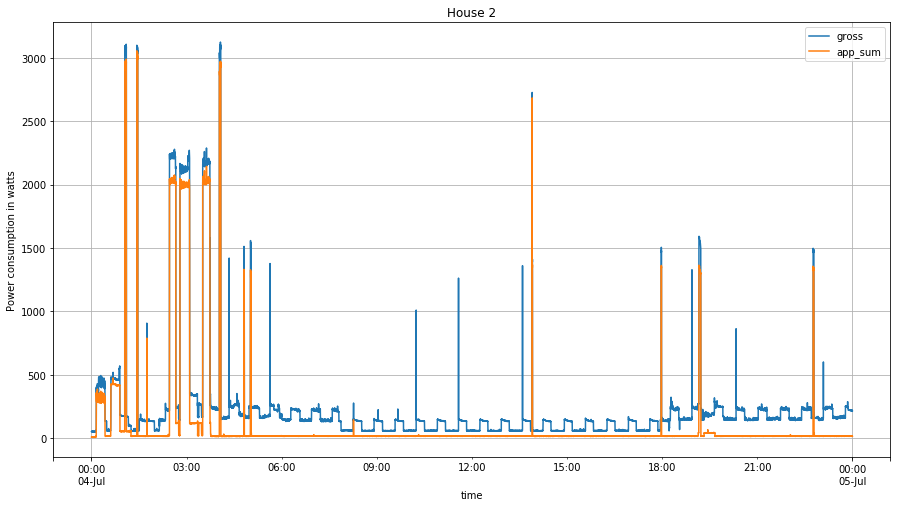

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ax = sub_df[['gross', 'app_sum']].plot(ax=ax)
ax.grid(True)
ax.set_title('House {}'.format(selected_hid))
ax.set_ylabel('Power consumption in watts')

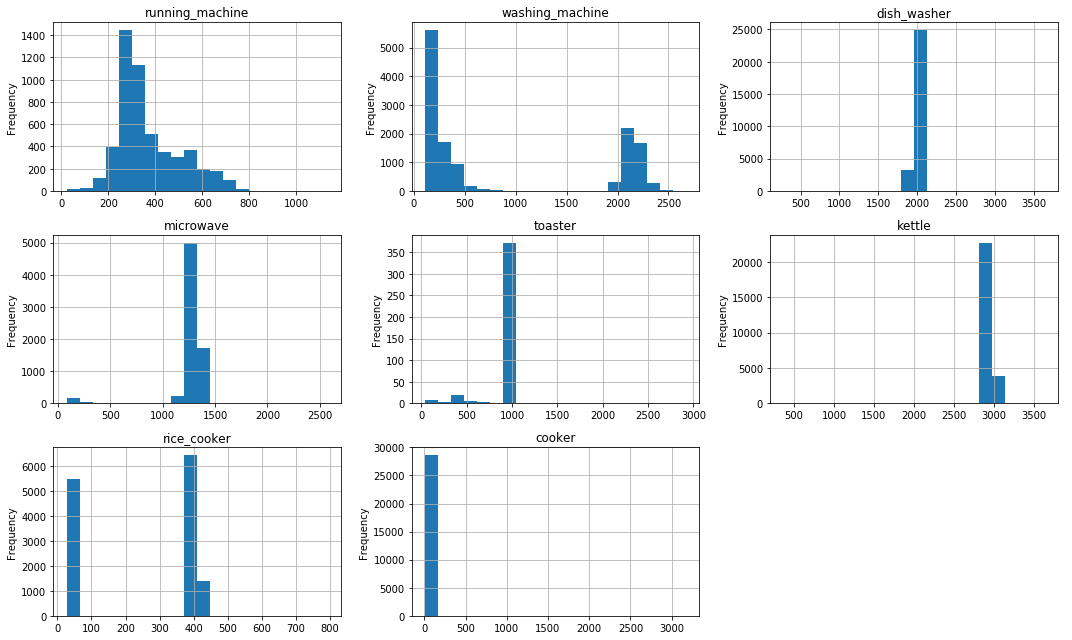

In [0]:
nrow = int(np.ceil(np.sqrt(len(appliance_cols))))
ncol = int(np.ceil(1.0 * len(appliance_cols) / nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(5*ncol, 3*nrow))
axes[-1, -1].axis('off')

for i, app in enumerate(appliance_cols):
  row_ix = i // 3
  col_ix = i % 3
  ax = axes[row_ix][col_ix]
  lb = energy_data[app].std()
  ub = energy_data[app].max() - lb
  energy_data[app + '_on'] = energy_data[app].apply(
      lambda x: 1 if x > lb else 0)
  energy_data[app][(energy_data[app] > lb) & 
                   (energy_data[app] < ub)].plot.hist(bins=20, ax=ax)
  ax.set_title(app)
  ax.grid(True)

plt.tight_layout()

In [0]:
energy_data.mean(axis=0)

modem                   8.993531
cooker                  0.179909
rice_cooker             2.912218
kettle                 45.684668
monitor                25.879006
laptop                 11.067621
router                  6.108015
server_hdd              2.018849
server                 13.867601
speakers                6.960742
playstation             0.955334
toaster                 0.598290
fridge                 54.477487
microwave               5.424965
laptop2                 3.729172
running_machine         2.793177
washing_machine        10.207630
dish_washer            33.497187
gross                 235.355403
app_sum               101.298045
running_machine_on      0.002954
washing_machine_on      0.007450
dish_washer_on          0.015989
microwave_on            0.004114
toaster_on              0.000238
kettle_on               0.015229
rice_cooker_on          0.007583
cooker_on               0.016298
dtype: float64

In [0]:
train_st = '2013-06-01 00:00:00'
train_et = '2013-07-31 23:59:59'
train_data = energy_data.loc[train_st:train_et]
print(train_data.shape)

valid_st = '2013-08-01 00:00:00'
valid_et = '2013-08-31 23:59:59'
valid_data = energy_data.loc[valid_st:valid_et]
print(valid_data.shape)

test_st = '2013-09-01 00:00:00'
test_et = '2013-09-30 23:59:59'
test_data = energy_data.loc[test_st:test_et]
print(test_data.shape)

(878400, 28)
(446400, 28)
(432000, 28)


In [0]:
train_file = os.path.join(raw_data_dir, 'house_{}/train.csv'.format(selected_hid))
valid_file = os.path.join(raw_data_dir, 'house_{}/valid.csv'.format(selected_hid))
test_file = os.path.join(raw_data_dir, 'house_{}/test.csv'.format(selected_hid))

In [0]:
with open(train_file, 'w') as f:
  train_data.to_csv(f)
print('train_data saved.')

with open(valid_file, 'w') as f:
  valid_data.to_csv(f)
print('valid_data saved.')
  
with open(test_file, 'w') as f:
  test_data.to_csv(f)
print('test_data saved.')

train_data saved.
valid_data saved.
test_data saved.


## Splitted Data inspection

In [0]:
train_file = os.path.join(raw_data_dir, 'house_{}/train.csv'.format(selected_hid))
valid_file = os.path.join(raw_data_dir, 'house_{}/valid.csv'.format(selected_hid))
test_file = os.path.join(raw_data_dir, 'house_{}/test.csv'.format(selected_hid))

In [0]:
# @title Peek at the input file

with open(train_file, 'r') as f:
  train_data = pd.read_csv(f, index_col=0)

print(pd.Series(train_data.columns))
train_data.head()

0                  modem
1                 cooker
2            rice_cooker
3                 kettle
4                monitor
5                 laptop
6                 router
7             server_hdd
8                 server
9               speakers
10           playstation
11               toaster
12                fridge
13             microwave
14               laptop2
15       running_machine
16       washing_machine
17           dish_washer
18                 gross
19               app_sum
20    running_machine_on
21    washing_machine_on
22        dish_washer_on
23          microwave_on
24            toaster_on
25             kettle_on
26        rice_cooker_on
27             cooker_on
dtype: object


,modem,cooker,rice_cooker,kettle,monitor,laptop,router,server_hdd,server,speakers,...,gross,app_sum,running_machine_on,washing_machine_on,dish_washer_on,microwave_on,toaster_on,kettle_on,rice_cooker_on,cooker_on
time,,,,,,,,,,,,,,,,,,,,,
2013-06-01 00:00:00,9,0,1,1,60,47,6,1,13,10,...,162,6,0,0,0,0,0,0,0,0
2013-06-01 00:00:06,9,0,1,1,60,53,6,1,14,10,...,169,6,0,0,0,0,0,0,0,0
2013-06-01 00:00:12,9,0,1,1,60,50,7,1,14,10,...,167,6,0,0,0,0,0,0,0,0
2013-06-01 00:00:18,9,0,1,1,60,50,7,1,14,10,...,169,7,0,0,0,0,0,0,0,0
2013-06-01 00:00:24,9,0,1,1,60,52,6,1,14,10,...,170,7,0,0,0,0,0,0,0,0


In [0]:
appliance_cols = [x for x in train_data.columns if '_on' in x]
print(train_data[appliance_cols].mean())

running_machine_on    0.002672
washing_machine_on    0.008931
dish_washer_on        0.018990
microwave_on          0.005001
toaster_on            0.000322
kettle_on             0.007234
rice_cooker_on        0.007342
cooker_on             0.018437
dtype: float64


In [0]:
with open(test_file, 'r') as f:
  test_data = pd.read_csv(f, index_col=0)

print(test_data.shape)
print(test_data[appliance_cols].mean())

(432000, 28)
running_machine_on    0.004553
washing_machine_on    0.006600
dish_washer_on        0.016924
microwave_on          0.004227
toaster_on            0.000104
kettle_on             0.008106
rice_cooker_on        0.007706
cooker_on             0.016333
dtype: float64


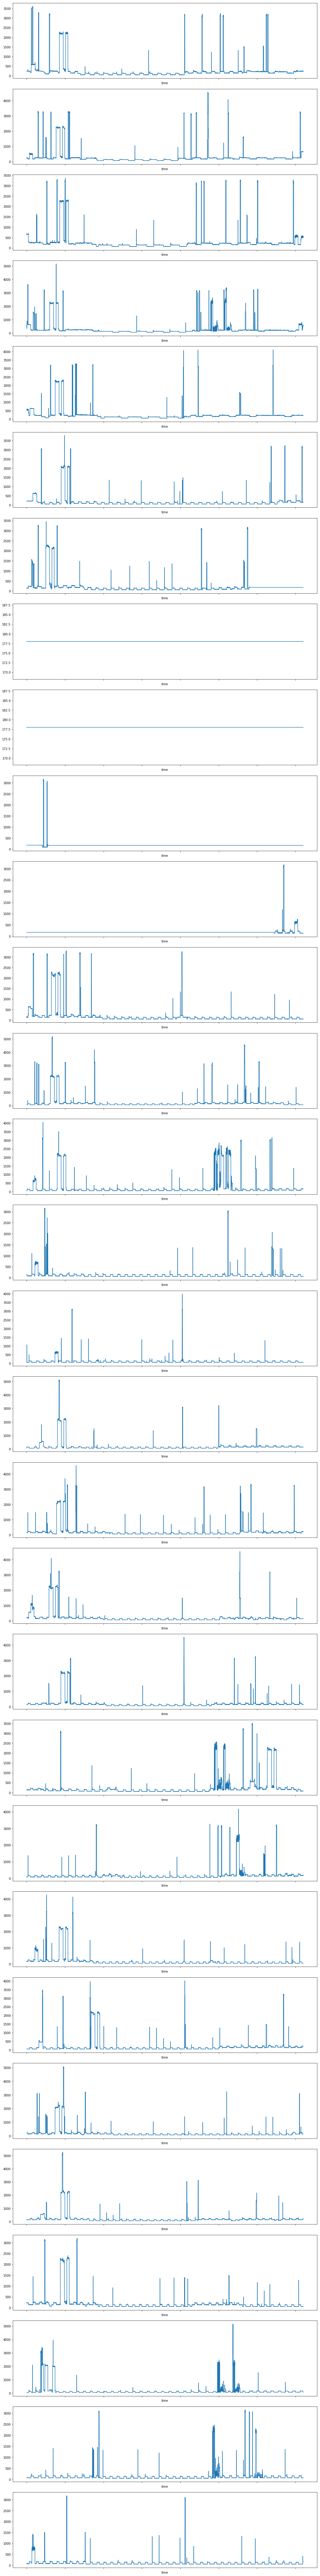

In [0]:
ss = ['2013-09-{0:02d} 00:00:00'.format(i+1) for i in range(30)]
ee = ['2013-09-{0:02d} 23:59:59'.format(i+1) for i in range(30)]


fig, axes = plt.subplots(30, 1, figsize=(15, 120))
for i, (s, e) in enumerate(zip(ss, ee)):
  test_data.loc[s:e].gross.plot(ax=axes[i])
  axes[i].set
plt.tight_layout()